In [1]:
import numpy as np
import pandas as pd
from PIL import Image as pilImg
from PIL import Image
import os 
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
char_list = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ' # 95 chars
vocabulary = sorted(set(char_list))

char_to_index = {char: i for i, char in enumerate(vocabulary)}
index_to_char = {i: char for char, i in char_to_index.items()}
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(char_list)+1
batch_size=64
max_length=14 # considering max length of ground truths labels to be 15


Loading Training,Testing and Validation images

In [3]:
train_images_path = pd.read_csv(r"Train_Final.csv",nrows = 2000)
train_images_path.drop(['Unnamed: 0'],axis = 1 , inplace = True)
train_images_path.head()

,ImageName,Labels
0,SynthImageDataset/2425/1/115_Lube_45484.jpg,LUBE
1,SynthImageDataset/2425/1/114_Spencerian_73323.jpg,SPENCERIAN
2,SynthImageDataset/2425/1/112_CARPENTER_11682.jpg,CARPENTER
3,SynthImageDataset/2425/1/110_savannas_67969.jpg,SAVANNAS
4,SynthImageDataset/2425/1/109_unfix_82473.jpg,UNFIX


In [4]:
# Loading Training Images
tra_image_paths = train_images_path['ImageName']
train_labels = train_images_path['Labels'].values

In [5]:
print("Number of training images:", len(tra_image_paths))
print("Number of labels:", len(train_labels))


Number of training images: 2000
Number of labels: 2000


In [6]:
validation_images_path = pd.read_csv(r"Validation_Final.csv",nrows = 200)
validation_images_path.drop(['Unnamed: 0'],axis = 1 , inplace = True)
validation_images_path.head()

,ImageName,Labels
0,SynthImageDataset/2697/6/466_MONIKER_49537.jpg,MONIKER
1,SynthImageDataset/2697/6/464_FIRESTORM_29099.jpg,FIRESTORM
2,SynthImageDataset/2697/6/462_Repurchases_64997...,REPURCHASES
3,SynthImageDataset/2697/6/461_PIGTAIL_57575.jpg,PIGTAIL
4,SynthImageDataset/2697/6/460_landladies_43270.jpg,LANDLADIES


In [7]:
# Loading Validation Images
valid_image_paths = validation_images_path['ImageName']
valid_labels = validation_images_path['Labels'].values

In [8]:
print("Number of Validation images:", len(valid_image_paths))
print("Number of labels:", len(valid_labels))

Number of Validation images: 200
Number of labels: 200


In [9]:
test_images_path = pd.read_csv(r"Test_Final.csv",nrows = 500)
test_images_path.drop(['Unnamed: 0'],axis = 1 , inplace = True)
test_images_path.head()

,ImageName,Labels
0,SynthImageDataset/3000/7/182_slinking_71711.jpg,SLINKING
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg,REMODELERS
2,SynthImageDataset/3000/7/180_Chronographs_1353...,CHRONOGRAPHS
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg,IMPEACHING
4,SynthImageDataset/3000/7/177_Loots_45256.jpg,LOOTS


In [10]:
# Loading Test Images
test_image_paths = test_images_path['ImageName']
test_labels = test_images_path['Labels'].values

In [11]:
print("Number of testing images:", len(test_image_paths))
print("Number of labels:", len(test_labels))

Number of testing images: 500
Number of labels: 500


Displaying images with labels

In [12]:
def plot_sample(X,y,index):
    plt.figure(figsize = (5,5))
    img_path = X[index]
    img = cv2.imread(img_path)
    plt.imshow(img)
    print(y[index])
    plt.show

SPENCERIAN


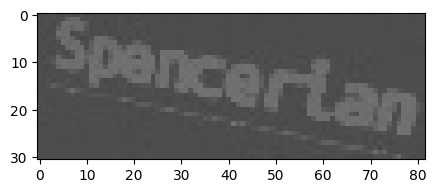

In [13]:
plot_sample(tra_image_paths,train_labels,1)

FIRESTORM


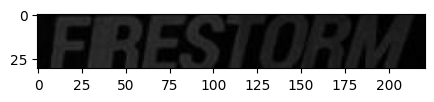

In [14]:
plot_sample(valid_image_paths,valid_labels,1)

REMODELERS


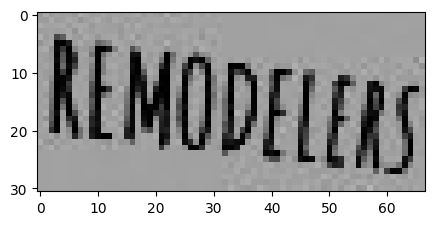

In [15]:
plot_sample(test_image_paths,test_labels,1)

Preprocessing Images

In [16]:
def preprocess_image(image_path, target_height=32, target_width=170):
    image = Image.open(image_path)
    image = image.convert("L")
    image = image.resize((target_width, target_height),resample=Image.BICUBIC)
    image_array = np.array(image) / 255.0    
    return image_array

In [17]:
#Preprocessing Training images
preprocessed_training_images = []
for image_path in tra_image_paths:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_training_images.append(preprocessed_image)
preprocessed_images_array1 = np.array(preprocessed_training_images)

print("Shape of preprocessed train images array:", preprocessed_images_array1.shape)


Shape of preprocessed train images array: (2000, 32, 170)


In [18]:
#Preprocessing Validation images
preprocessed_validation_images = []
for image_path in valid_image_paths:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_validation_images.append(preprocessed_image)
preprocessed_images_array2 = np.array(preprocessed_validation_images)

print("Shape of preprocessed Validation images array:", preprocessed_images_array2.shape)

Shape of preprocessed Validation images array: (200, 32, 170)


In [19]:
#Preprocessing test images
preprocessed_test_images = []
for image_path in test_image_paths:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_test_images.append(preprocessed_image)
preprocessed_images_array3 = np.array(preprocessed_test_images)

print("Shape of preprocessed Test images array:", preprocessed_images_array3.shape)

Shape of preprocessed Test images array: (500, 32, 170)


In [20]:
w = "word"
list(w)

['w', 'o', 'r', 'd']

Preprocessing Labels

In [21]:
def preprocess_text(text_list, max_length):
    normalized_word_list = text_list
    tokenized_word_list = [list(word) for word in normalized_word_list]
    #print("tokenized_word_list : ", tokenized_word_list[:5])
    encoded_word_list = [[char_to_index[char] for char in word] for word in tokenized_word_list]
    #encoded_word_list = [[char_to_index.get(char, len(vocabulary) - 1) for char in word] for word in tokenized_word_list]

    padded_word_list = pad_sequences(encoded_word_list, maxlen=max_length, padding='post')

    num_classes = len(vocabulary)
    one_hot_encoded_list = [np.eye(num_classes)[word] for word in padded_word_list]

    one_hot_encoded_array = np.array(one_hot_encoded_list)
    one_hot_encoded_array = one_hot_encoded_array.reshape(-1, max_length, num_classes)

    return padded_word_list, one_hot_encoded_array


In [22]:
text_list1 = train_labels
padded_word_list1, one_hot_encoded_array1 = preprocess_text(text_list1, max_length)

print("Padded word list shape of training labels:", padded_word_list1.shape)
print("One-hot encoded array shape of training labels:", one_hot_encoded_array1.shape)

Padded word list shape of training labels: (2000, 14)
One-hot encoded array shape of training labels: (2000, 14, 95)


In [23]:
text_list2 = valid_labels
padded_word_list2, one_hot_encoded_array2 = preprocess_text(text_list2, max_length)

print("Padded word list shape of validation labels:", padded_word_list2.shape)
print("One-hot encoded array shape of validation labels:", one_hot_encoded_array2.shape)

Padded word list shape of validation labels: (200, 14)
One-hot encoded array shape of validation labels: (200, 14, 95)


In [24]:
text_list3 = test_labels
padded_word_list3, one_hot_encoded_array3 = preprocess_text(text_list3, max_length)

print("Padded word list shape of test labels:", padded_word_list3.shape)
print("One-hot encoded array shape of test labels:", one_hot_encoded_array3.shape)

Padded word list shape of test labels: (500, 14)
One-hot encoded array shape of test labels: (500, 14, 95)


Modeling

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Reshape, Bidirectional, LSTM, Lambda
from tensorflow.keras import models,layers
from keras import backend as K

In [26]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Activation, LSTM, Bidirectional, TimeDistributed, Dense, Lambda
import tensorflow as tf

# Define the model
model = models.Sequential()

# Convolution layers
model.add(Conv2D(64, (3, 3), activation="relu", padding='same', input_shape=(32, 170, 1), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(layers.SeparableConv2D(128, (3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(layers.SeparableConv2D(256, (3, 3), activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 3)))
model.add(Dropout(0.3))
model.add(BatchNormalization())


model.add(layers.SeparableConv2D(512, (3, 3),activation = "relu", padding='same'))
model.add(MaxPooling2D(pool_size=(4, 1)))
model.add(Dropout(0.25))
model.add(BatchNormalization())



# Lambda layer to squeeze one dimension
model.add(Lambda(lambda x: tf.squeeze(x, axis=1)))

# RNN layers
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum'))
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum'))

# Time distributed dense layer
model.add(TimeDistributed(Dense(95, activation='softmax')))

# Print the summary
model.summary()


E:\python\python 3123\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 170, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 16, 85, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 42, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 8, 42, 256)          │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 14, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 4, 14, 512)          │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 14, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 14, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 14, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 14, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 14, 256)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 14, 256)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 14, 95)              │          24,415 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,831,391 (10.80 MB)

 Trainable params: 2,829,471 (10.79 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [27]:
model.outputs

[<KerasTensor shape=(None, 14, 95), dtype=float32, sparse=False, name=keras_tensor_179>]

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Assuming you have training_data and validation_data
model.fit(preprocessed_images_array1,one_hot_encoded_array1, batch_size= 32, epochs= 15, validation_data=[preprocessed_images_array2, one_hot_encoded_array2])


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - accuracy: 0.3984 - loss: 2.5947 - val_accuracy: 0.4546 - val_loss: 1.9886
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.4648 - loss: 1.9008 - val_accuracy: 0.4546 - val_loss: 1.9620
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.4700 - loss: 1.8565 - val_accuracy: 0.4514 - val_loss: 1.9720
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.4745 - loss: 1.8208 - val_accuracy: 0.4468 - val_loss: 1.9555
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.4758 - loss: 1.8150 - val_accuracy: 0.4354 - val_loss: 1.9601
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.4822 - loss: 1.7838 - val_accuracy: 0.4279 - val_loss: 1.9898
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.4834 - loss: 1.7535 - val_accuracy: 0.4664 - val_loss: 1.8882
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.4912 - loss: 1.7402 - val_accu

In [30]:
import pickle
file_path = "textrecognition_model(2000,200,500).pkl"
with open(file_path, 'wb') as f:
    pickle.dump(model, f)

AttributeError: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'

In [ ]:
y_pred=model.predict(preprocessed_images_array3)

In [ ]:
y_pred.shape

In [ ]:
char_to_index = {char: i for i, char in enumerate(vocabulary)}
index_to_char = {i: char for char, i in char_to_index.items()}

In [ ]:
print("character to index:",char_to_index,"\n")
print("index to charcater:",index_to_char,"\n")

In [ ]:
def unpad_sequence(seq):
    return [index for index in seq if index != 0]

In [ ]:
def custom_ctc_decoder(actual,pred):
    pred_list = np.argmax(pred, axis=-1)
    actual_list = np.argmax(actual, axis=-1)
    decoded_pred_list = [[index_to_char[index] for index in unpad_sequence(seq)] for seq in pred_list]
    decoded_pred_list = [''.join(word) for word in decoded_pred_list]
    decoded_actual_list = [[index_to_char[index] for index in unpad_sequence(seq)] for seq in actual_list]
    decoded_actual_list = [''.join(word) for word in decoded_actual_list]
    return decoded_actual_list,decoded_pred_list

In [ ]:
act,pred=custom_ctc_decoder(one_hot_encoded_array1,y_pred)

In [ ]:
act